# Hierarchical Network Embedding for Community Detection

## Imports

In [1]:
import time
import collections

import numpy as np

import torch, torch.nn as nn, torch.autograd as autograd
import torch.utils.data
from torch.distributions import multivariate_normal

from dgl import DGLGraph
from dgl.data import citation_graph as citegrh

import networkx as nx

import matplotlib.pyplot as plt

## Constants

In [2]:
N    = 2708
D    = 400
K    = 7
eps  = 1e-6
beta = 1e-4

batch_size = 300

# FIXME: restrict propbability density functions
max_density = 2.

## Utility functions

In [3]:
def vectorize(row):
    return np.array(row.split(" ")).astype(float)

def skipgram2dict(skipgram):
    d = dict(skipgram[i].split(" ", 1) for i in range(len(skipgram)))
    d = {int(num): vectorize(v) for num, v in d.items()}
    
    return collections.OrderedDict(sorted(d.items()))

def normalize(v):
    min_v = torch.min(v)
    range_v = torch.max(v) - min_v
    
    if range_v > 0:
        return (v - min_v) / range_v
    else:
        return torch.zeros(vector.size())

In [38]:
#!deepwalk --help

#!deepwalk --input ../graphsage/cora/cora.adjlist --representation-size 400 --walk-length 40 --output ../graphsage/cora/cora.embeddings

## Data preparation

In [4]:
with open("../graphsage/cora/cora.embeddings", "r") as f:
    skipgram = f.readlines()
    
print("Number of nodes: {} in {}-dimensional representation".format(*skipgram.pop(0).split()))
    
dataset = skipgram2dict(skipgram)

Number of nodes: 2708 in 400-dimensional representation


## Mixed-community membership

In [5]:
def KMeans(x, K, Niter=10, verbose=False):
    N, D = x.shape  # Number of samples, dimension of the ambient space

    # K-means loop:
    # - x  is the point cloud,
    # - cl is the vector of class labels
    # - c  is the cloud of cluster centroids
    start = time.time()
    c     = x[:K, :].clone()  # Simplistic random initialization
    x_i   = torch.tensor(x[:, None, :])  # (Npoints, 1, D)

    for i in range(Niter):

        c_j  = torch.tensor(c[None, :, :])  # (1, Nclusters, D)
        D_ij = ((x_i - c_j) ** 2).sum(-1)  # (Npoints, Nclusters) symbolic matrix of squared distances
        cl   = D_ij.argmin(dim=1).long().view(-1)  # Points -> Nearest cluster
        pi   = 1 - normalize(D_ij)

        Ncl = torch.bincount(cl).float()  # Class weights
        for d in range(D):  # Compute the cluster centroids with torch.bincount:
            c[:, d] = torch.bincount(cl, weights=x[:, d]) / Ncl

    end = time.time()

    if verbose:
        print("K-means example with {:,} points in dimension {:,}, K = {:,}:".format(N, D, K))
        print('Timing for {} iterations: {:.5f}s = {} x {:.5f}s\n'.format(
                Niter, end - start, Niter, (end - start) / Niter))

    return cl, pi

In [6]:
model = nn.Sequential(
    nn.Linear(400, 1024),
    nn.Dropout(0.05),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.Dropout(0.05),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.Dropout(0.05),
    nn.ReLU(),
    nn.Linear(256, 400),
    nn.Softmax()
)

In [7]:
train_batch_gen  = torch.utils.data.DataLoader(dataset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)

## [ComE](https://sentic.net/community-embedding.pdf) algorithm

In [8]:
def compute_loss(model, X_batch, pi, psi, Sigma):
    X_batch = model(X_batch)
    # Probabilities (X_batch, K)
    log_probs         = compute_probs(X_batch, psi, Sigma)
    probs             = torch.clamp(log_probs.exp(), min=eps)
    # Gamma (X_batch, K)
    gamma             = compute_gamma(pi, probs)
    # N (1, K)
    N                 = gamma.sum(dim=0, keepdim=True)
    # Pi (1, K)
    pi                = N / X_batch.size(0)
    # Psi (K)
    psi               = []
    # Sigma (K)
    Sigma             = []
    
    for k in range(K):
        psi_k   = compute_mean_k(N[:, k], gamma[:, k], X_batch)
        Sigma_k = compute_cov_k(N[:, k], gamma[:, k], X_batch, psi_k)
        
        psi.append(psi_k.view(X_batch.size()[1]))
        Sigma.append(torch.diagflat(Sigma_k))
    
    loss = -(beta / K) * torch.sum(torch.sum(torch.log(pi * probs), dim=1, keepdim=True))
    
    return psi, Sigma, loss

def compute_probs(X_batch, psi, Sigma):
    probs = torch.FloatTensor()
    
    for psi_k, Sigma_k in list(zip(psi, Sigma)):
        normal_k = multivariate_normal.MultivariateNormal(psi_k, Sigma_k)
        # Probability (X_batch, 1)
        prob_k   = normal_k.log_prob(X_batch).view(X_batch.size()[0], 1)
        prob_k   = torch.clamp(prob_k, max=max_density)
        probs    = torch.cat((probs, prob_k), dim=1)
        
    return probs

def compute_gamma(pi, probs):
    gamma_numerator   = pi * probs
    gamma_denominator = torch.sum(gamma_numerator, dim=1, keepdim=True)
    
    return torch.div(gamma_numerator, gamma_denominator)
    
def compute_mean_k(N_k, gamma_k, X_batch):
    return (1 / N_k) * torch.sum(gamma_k.view(-1, 1) * X_batch, dim=0, keepdim=True)

def compute_cov_k(N_k, gamma_k, X_batch, psi_k):
    return (1 / N_k) * torch.sum(gamma_k.view(-1, 1) * (X_batch - psi_k) * (X_batch - psi_k), dim=0, keepdim=True) + eps

def reset_mean(X_batch):
    data    = X_batch.numpy()
    psi_k   = np.mean(data, axis=0)
    psi_k   = torch.tensor(psi_k, dtype=torch.float, requires_grad=True)
    
    return psi_k

def reset_cov(X_batch):
    data    = X_batch.numpy()
    Sigma_k = np.cov(data, rowvar=False)
    # Ensure that the covariance matrix is positive semi-definite
    Sigma_k = np.add(Sigma_k, np.eye(400) * eps)
    Sigma_k = torch.tensor(Sigma_k, dtype=torch.float, requires_grad=True)
    
    return Sigma_k

In [9]:
torch.manual_seed(1234)

psi   = []
Sigma = []

num_epochs = 1
train_loss = []

opt = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.1)

train_batch_gen_iter = iter(train_batch_gen)

for i in range(K):
    X_batch = next(train_batch_gen_iter)
    psi_k   = reset_mean(X_batch.float())
    Sigma_k = reset_cov(X_batch.float())
    
    psi.append(psi_k)
    Sigma.append(Sigma_k)

for epoch in range(num_epochs):
    model.train(True)
    
    print("Epoch: {}".format(epoch))
    
    for X_batch in train_batch_gen:        
        with autograd.detect_anomaly():
            # Obtain mixed-community membership
            labels, pi       = KMeans(X_batch, K)
            # Update pi, mean, cov
            psi, Sigma, loss = compute_loss(model, X_batch.float(), pi.float(), psi, Sigma)
            
            loss.backward(retain_graph=True)
            
            opt.step()
            opt.zero_grad()
            
        train_loss.append(loss.data.cpu().numpy())
        
    print("Training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(dataset) // batch_size :]))
    )

model.train(False)

Epoch: 0


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training loss (in-iteration): 	0.001595


Sequential(
  (0): Linear(in_features=400, out_features=1024, bias=True)
  (1): Dropout(p=0.05, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): Dropout(p=0.05, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=256, bias=True)
  (7): Dropout(p=0.05, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=400, bias=True)
  (10): Softmax(dim=None)
)

## Tests

In [10]:
e      = list(dataset.values())
x      = torch.tensor(e).float()
output = model(x)

# log_probs       = compute_probs(x, psi, Sigma)
# probs           = log_probs.exp()
labels, pi      = KMeans(x, K, Niter=100)
labels2, pi2    = KMeans(output, K, Niter=100)

labels          = labels.detach().numpy()
labels2         = labels2.detach().numpy()

print(np.sum(labels==0),
      np.sum(labels==1),
      np.sum(labels==2),
      np.sum(labels==3),
      np.sum(labels==4),
      np.sum(labels==5),
      np.sum(labels==6))

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


124 661 250 585 434 447 207


In [11]:
data = citegrh.load_cora()
G    = DGLGraph(data.graph)
kn   = G.to_networkx()
pos  = nx.spring_layout(kn)

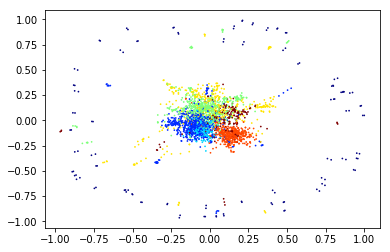

In [12]:
nc = nx.draw_networkx_nodes(kn, pos, node_color=labels,
                            with_labels=False, node_size=0.5, cmap=plt.cm.jet)

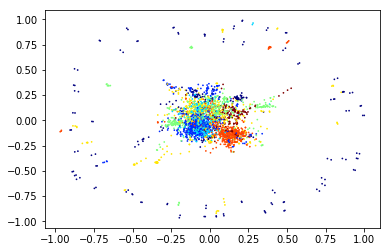

In [13]:
nc = nx.draw_networkx_nodes(kn, pos, node_color=labels2,
                            with_labels=False, node_size=0.5, cmap=plt.cm.jet)